In [106]:
# !apt-get install -y -qq software-properties-common python-software-properties module-init-tools

# !add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null

# !apt-get update -qq 2>&1 > /dev/null

# !apt-get -y install -qq google-drive-ocamlfuse fuse

# from google.colab import auth

# auth.authenticate_user()


# from oauth2client.client import GoogleCredentials

# creds = GoogleCredentials.get_application_default()

# import getpass

# !google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL

# vcode = getpass.getpass()

# !echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}


# !mkdir -p drive

# !google-drive-ocamlfuse drive

In [107]:
# !ls drive/ColabNotebooks/

In [108]:
import numpy as np
import csv
import math
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from scipy.sparse import coo_matrix
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

In [124]:
def initialize_parameters(n_input, n_hidden, solver): # initialize parameters with tiny random numbers
    num_of_layers = len(n_hidden)
    parameters = {}
    v = {}
    s = {}
    
    parameters['w1'] = np.random.randn(n_hidden[0], n_input) * np.sqrt(2/n_input)
    parameters['b1'] = np.zeros((n_hidden[0], 1))
    
    if solver=='momentum' or solver=='adam':
        v['dw1'] = np.zeros(parameters['w1'].shape)
        v['db1'] = np.zeros(parameters['b1'].shape)
    if solver=='rmsprop' or solver=='adam':
        s['dw1'] = np.zeros(parameters['w1'].shape)
        s['db1'] = np.zeros(parameters['b1'].shape)
    
    for i in range(1, num_of_layers):
        parameters['w'+str(i+1)] = np.random.randn(n_hidden[i], n_hidden[i-1]) * np.sqrt(2/n_hidden[i-1])
        parameters['b'+str(i+1)] = np.zeros((n_hidden[i], 1))
        
        if solver=='momentum' or solver=='adam':
            v['dw'+str(i+1)] = np.zeros(parameters['w'+str(i+1)].shape)
            v['db'+str(i+1)] = np.zeros(parameters['b'+str(i+1)].shape)
        if solver=='rmsprop' or solver=='adam':
            s['dw'+str(i+1)] = np.zeros(parameters['w'+str(i+1)].shape)
            s['db'+str(i+1)] = np.zeros(parameters['b'+str(i+1)].shape)
    
    parameters['w'+str(num_of_layers+1)] = np.random.randn(1, n_hidden[num_of_layers-1]) * np.sqrt(2/n_hidden[num_of_layers-1])
    parameters['b'+str(num_of_layers+1)] = np.zeros((1, 1))

    if solver=='momentum' or solver=='adam':
        v['dw'+str(num_of_layers+1)] = np.zeros(parameters['w'+str(num_of_layers+1)].shape)
        v['db'+str(num_of_layers+1)] = np.zeros(parameters['b'+str(num_of_layers+1)].shape)
    if solver=='rmsprop' or solver=='adam':
        s['dw'+str(num_of_layers+1)] = np.zeros(parameters['w'+str(num_of_layers+1)].shape)
        s['db'+str(num_of_layers+1)] = np.zeros(parameters['b'+str(num_of_layers+1)].shape)
    
    if solver=='momentum':
        return parameters, v
    elif solver=='rmsprop':
        return parameters, s
    elif solver=='adam':
        return parameters, v, s
    
    return parameters

In [110]:
def relu(z):
    return np.maximum(z, 0)

def relu_derivative(z):
    der = np.zeros(z.shape)
    der[z >= 0] = 1
    return der

In [111]:
def forward_prop(x, parameters, activation, keep_prob=1.0):
    cache = {}
    last_layer = len(parameters) // 2
    cache['a'+str(0)] = x
    
    for l in range(1, last_layer+1):
        cache['z'+str(l)] = np.dot(parameters['w'+str(l)], cache['a'+str(l-1)]) + parameters['b'+str(l)]
        if l == last_layer: 
            cache['a'+str(last_layer)] = 1/(1 + np.exp(-cache['z'+str(last_layer)]))
        elif activation == 'relu':
            cache['a'+str(l)] = relu(cache['z'+str(l)])
        elif activation == 'sigmoid': 
            cache['a'+str(l)] = 1/(1 + np.exp(-cache['z'+str(l)]))
        elif activation == 'tanh': 
            cache['a'+str(l)] = np.tanh(cache['z'+str(l)])
        
        if keep_prob != 1.0 and l != last_layer:
            dropout_temp = np.random.randn(cache['a'+str(l)].shape[0], cache['a'+str(l)].shape[1]) < keep_prob
            cache['dropout_vec'+str(l)] = dropout_temp 
            cache['a'+str(l)] = np.multiply(cache['a'+str(l)], dropout_temp) / keep_prob

    return cache

In [112]:
def back_prop(x, y, cache, parameters, activation, _lambda, keep_prob):
    m = x.shape[1]
    gradients = {}
    last_layer = len(parameters) // 2

    gradients['dz'+str(last_layer)] = cache['a'+str(last_layer)] - y.T
    gradients['dw'+str(last_layer)] = 1/m * np.dot(gradients['dz'+str(last_layer)], cache['a'+str(last_layer-1)].T) + _lambda/m * parameters['w'+str(last_layer)]
    gradients['db'+str(last_layer)] = 1/m * np.sum(gradients['dz'+str(last_layer)], axis=1, keepdims=True)
        
    for i in reversed(range(1, last_layer)):
        dA = np.dot(parameters['w'+str(i+1)].T, gradients['dz'+str(i+1)])
        if keep_prob != 1.0 and i != last_layer:
            dA *= cache['dropout_vec'+str(i)]
            dA /= keep_prob
            
        if activation == 'sigmoid': 
            sigmoid = 1/(1 + np.exp(-cache['z'+str(i)]))
            gradients['dz'+str(i)] = dA * (sigmoid * (1 - sigmoid))
        elif activation == 'relu':
            gradients['dz'+str(i)] = dA * relu_derivative(cache['z'+str(i)])
        elif activation == 'tanh': 
            gradients['dz'+str(i)] = dA * (1 - np.power(np.tanh(cache['z'+str(i)]), 2))
            
        gradients['dw'+str(i)] = 1/m * np.dot(gradients['dz'+str(i)], cache['a'+str(i-1)].T) + _lambda/m * parameters['w'+str(i)]
        gradients['db'+str(i)] = 1/m * np.sum(gradients['dz'+str(i)], axis=1, keepdims=True)
        
    return gradients

In [113]:
def cost_function(m, labels, y_hat, params, lambd): # regularized
    last_layer = len(params) // 2
    return -1/m * (np.sum(labels * np.log(y_hat)) + np.sum((1-labels) * np.log(1 - y_hat))) + lambd/(2*m) * np.sum([
            np.power(np.linalg.norm(params['w'+str(i)]), 2) for i in range(1, last_layer+1)])

In [114]:
def load_weights(num):
    parameters = {}
    for i in range(1, num+1):
        parameters["w"+str(i)] = np.load("w"+str(i)+".npy")
        parameters["b"+str(i)] = np.load("b"+str(i)+".npy")
    return parameters

In [115]:
params = load_weights(4)

In [126]:
def multi_Layer_NN(samples, labels, n_hidden, num_iterations, solver='gd', batch_size=None, activation="tanh", learning_rate=0.01, momentum_param=0.9, rmsprop_param=0.999, epsilon=10e-8, _lambda=0, keep_prob_dropout=1.0, print_cost=False):
    m = samples.shape[1]
    if not batch_size: batch_size = m
    
    if solver=='gd':
        params = initialize_parameters(samples.shape[0], n_hidden, solver)
    elif solver=='momentum':
        params, v = initialize_parameters(samples.shape[0], n_hidden, solver)
    elif solver=='rmsprop':
        params, s = initialize_parameters(samples.shape[0], n_hidden, solver)
    elif solver=='adam':
        params, v, s = initialize_parameters(samples.shape[0], n_hidden, solver)
            
    cost_history = []
    last_layer = len(params) // 2
    
    for i in range(1, num_iterations+1):
        
        for t in range(math.ceil(m/batch_size)):
            
            cache = forward_prop(samples[:, int(t*batch_size):int((t+1)*batch_size)], params, activation, keep_prob_dropout)
            
            gradients = back_prop(samples[:, int(t*batch_size):int((t+1)*batch_size)],
                                  labels[int(t*batch_size):int((t+1)*batch_size)], 
                                  cache, 
                                  params, 
                                  activation,
                                  _lambda, 
                                  keep_prob_dropout)
            
            if solver=='gd':
                for j in range(1, last_layer+1):
                    params['w'+str(j)] -= learning_rate * gradients['dw'+str(j)]
                    params['b'+str(j)] -= learning_rate * gradients['db'+str(j)]
            elif solver=='momentum':
                for j in range(1, last_layer+1):
                    v['dw'+str(j)] = momentum_param*v['dw'+str(j)] + (1-momentum_param) * gradients['dw'+str(j)]
                    v['db'+str(j)] = momentum_param*v['db'+str(j)] + (1-momentum_param) * gradients['db'+str(j)]
                    params['w'+str(j)] -= learning_rate * v['dw'+str(j)]
                    params['b'+str(j)] -= learning_rate * v['db'+str(j)]
            elif solver=='rmsprop':
                for j in range(1, last_layer+1):
                    s['dw'+str(j)] = rmsprop_param*s['dw'+str(j)] + (1-rmsprop_param) * gradients['dw'+str(j)]**2
                    s['db'+str(j)] = rmsprop_param*s['db'+str(j)] + (1-rmsprop_param) * gradients['db'+str(j)]**2
                    params['w'+str(j)] -= learning_rate * gradients['dw'+str(j)]/(np.sqrt(s['dw'+str(j)] + epsilon))
                    params['b'+str(j)] -= learning_rate * gradients['db'+str(j)]/(np.sqrt(s['db'+str(j)] + epsilon))
            
            elif solver=='adam':
                for j in range(1, last_layer+1):
                    v['dw'+str(j)] = momentum_param*v['dw'+str(j)] + (1-momentum_param) * gradients['dw'+str(j)]
                    v['db'+str(j)] = momentum_param*v['db'+str(j)] + (1-momentum_param) * gradients['db'+str(j)]
                    s['dw'+str(j)] = rmsprop_param*s['dw'+str(j)] + (1-rmsprop_param) * gradients['dw'+str(j)]**2
                    s['db'+str(j)] = rmsprop_param*s['db'+str(j)] + (1-rmsprop_param) * gradients['db'+str(j)]**2
                    v_corrected_dw = v['dw'+str(j)]/(1-momentum_param**i)
                    v_corrected_db = v['db'+str(j)]/(1-momentum_param**i)
                    s_corrected_dw = s['dw'+str(j)]/(1-rmsprop_param**i)
                    s_corrected_db = s['db'+str(j)]/(1-rmsprop_param**i)
                    params['w'+str(j)] -= learning_rate * v_corrected_dw/(np.sqrt(s_corrected_dw) + epsilon)
                    params['b'+str(j)] -= learning_rate * v_corrected_db/(np.sqrt(s_corrected_db) + epsilon)
            
            if print_cost: 
                cost = cost_function(batch_size, labels[int(t*batch_size):int((t+1)*batch_size)], cache['a'+str(last_layer)].T, params, _lambda)
                print('cost after epoch {}: {}'.format(int(i), cost))
                cost_history.append(cost)
              
    return {'parameters':params, 
            'cache': cache,
            'cost_history':cost_history
           }


In [117]:
def predict(x, parameters, activation):
    last_layer = len(parameters) // 2
    cache = forward_prop(x.T, parameters, activation)
    y_hat = cache['a'+str(last_layer)]
    y_hat[y_hat >= 0.5] = 1
    y_hat[y_hat < 0.5] = 0

    return y_hat.T

## load dataset section

In [118]:
import scipy.io
samples = scipy.io.loadmat('olivettifaces.mat')
samples = samples['faces'].T
labels = np.ones((samples.shape[0], 1))
artificialZeroData = np.random.randint(0, 256, (samples.shape[0], samples.shape[1]))
artificialZeroLabel = np.zeros((artificialZeroData.shape[0], 1))
samples = np.vstack((samples, artificialZeroData))
labels = np.vstack((labels, artificialZeroLabel))

_mean = np.mean(samples, axis=1).reshape(-1, 1)
variance = (np.std(samples, axis=1)**2).reshape(-1, 1)
samples = (samples - _mean)/variance

samples_sparse = coo_matrix(samples)
samples, samples_sparse, labels = shuffle(samples, samples_sparse, labels)

train_data, test_data, train_label, test_label = train_test_split(samples, labels, test_size=0.30, random_state=4)

In [119]:
print(samples.shape, labels.shape)
print(train_data.shape, train_label.shape)
print(test_data.shape, test_label.shape)

(800, 4096) (800, 1)
(560, 4096) (560, 1)
(240, 4096) (240, 1)


## train section

In [131]:
import time

tic = time.time()
activation_function = 'tanh'
model = multi_Layer_NN(train_data.T,
                         train_label,
                         activation=activation_function,
                         n_hidden=[100, 100, 100],
                         num_iterations=50,
                         solver='adam',
                         momentum_param=0.9,
                         rmsprop_param=0.999,
                         epsilon=10e-2,
                         batch_size=64,
                         learning_rate=0.1,
                         _lambda = 0,
                         keep_prob_dropout=1,
                         print_cost=True)

print("Train phase time:", time.time()-tic)

cost after epoch 1: 0.7221779122316305
cost after epoch 1: 0.6010288981870808
cost after epoch 1: 0.26393060057120243
cost after epoch 1: 0.09338593303780757
cost after epoch 1: 0.01045000999677213
cost after epoch 1: 0.014114131676732599
cost after epoch 1: 1.0302771718735262e-05
cost after epoch 1: 5.294089882633911e-06
cost after epoch 1: 0.026877735848887318
cost after epoch 2: 5.990137393146248e-08
cost after epoch 2: 1.317515032734224e-07
cost after epoch 2: 1.4096736551156539e-08
cost after epoch 2: 1.1491769662769875e-08
cost after epoch 2: 6.7258362682095e-09
cost after epoch 2: 4.863125481352449e-09
cost after epoch 2: 3.5247078825220257e-09
cost after epoch 2: 2.6177815204236986e-09
cost after epoch 2: 1.4608306389878196e-09
cost after epoch 3: 1.3728334002501907e-09
cost after epoch 3: 1.600863319770533e-09
cost after epoch 3: 1.2071627578572065e-09
cost after epoch 3: 1.2146846039235588e-09
cost after epoch 3: 1.0796692940088843e-09
cost after epoch 3: 1.0369432195016088e-

cost after epoch 22: 5.302579991628032e-10
cost after epoch 22: 5.098030940225131e-10
cost after epoch 22: 3.526528063872399e-10
cost after epoch 23: 4.070186393897873e-10
cost after epoch 23: 4.744900325145449e-10
cost after epoch 23: 4.699445192120939e-10
cost after epoch 23: 5.309739178142779e-10
cost after epoch 23: 5.178971663161243e-10
cost after epoch 23: 5.452736007780713e-10
cost after epoch 23: 5.302577563015164e-10
cost after epoch 23: 5.098028581001202e-10
cost after epoch 23: 3.5265264852740343e-10
cost after epoch 24: 4.0701844163131094e-10
cost after epoch 24: 4.744898139393867e-10
cost after epoch 24: 4.699443006369359e-10
cost after epoch 24: 5.309736680140971e-10
cost after epoch 24: 5.178969199853905e-10
cost after epoch 24: 5.452733613862315e-10
cost after epoch 24: 5.302575082360591e-10
cost after epoch 24: 5.098026187082803e-10
cost after epoch 24: 3.5265248546339663e-10
cost after epoch 25: 4.0701826295479287e-10
cost after epoch 25: 4.744895953642287e-10
cost af

cost after epoch 44: 4.070148785092894e-10
cost after epoch 44: 4.744857755031318e-10
cost after epoch 44: 4.699401650561665e-10
cost after epoch 44: 5.309690016079432e-10
cost after epoch 44: 5.17892385418221e-10
cost after epoch 44: 5.452685440591349e-10
cost after epoch 44: 5.302528418299052e-10
cost after epoch 44: 5.097981517953263e-10
cost after epoch 44: 3.5264942194173583e-10
cost after epoch 45: 4.070147067716651e-10
cost after epoch 45: 4.744855829488259e-10
cost after epoch 45: 4.699399725018605e-10
cost after epoch 45: 5.309687778286146e-10
cost after epoch 45: 5.178921668430628e-10
cost after epoch 45: 5.452683185450831e-10
cost after epoch 45: 5.302526267241941e-10
cost after epoch 45: 5.097979314854448e-10
cost after epoch 45: 3.5264925714300546e-10
cost after epoch 46: 4.0701452289097654e-10
cost after epoch 46: 4.744853869250729e-10
cost after epoch 46: 4.699397504572555e-10
cost after epoch 46: 5.309685471103921e-10
cost after epoch 46: 5.178919413290108e-10
cost afte

In [132]:
pred_labels = predict(train_data, parameters=model['parameters'], activation=activation_function)
print('accuracy on train set:', (np.sum(pred_labels == train_label)/pred_labels.size) * 100, '%')
pred_labels = predict(test_data, parameters=model['parameters'], activation=activation_function)
print('accuracy on test set:', (np.sum(pred_labels == test_label)/pred_labels.size) * 100, '%')

accuracy on train set: 100.0 %
accuracy on test set: 100.0 %


### plot cost value

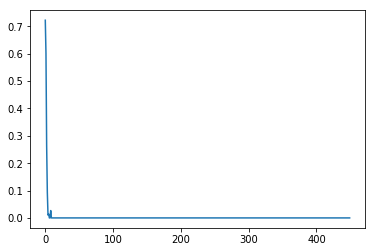

In [133]:
plt.plot(range(len(model['cost_history'])), model['cost_history'])
plt.show()

### test an example of test set

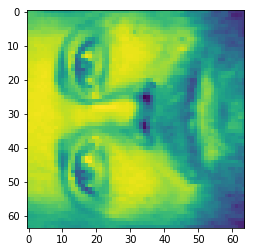

[[1.]]
Human


In [141]:
photo_number = np.random.randint(0, test_data.shape[0])
imgplot = plt.imshow(test_data[photo_number].reshape(64, 64))
plt.show()
pred_labels = predict(test_data[photo_number].reshape(1, -1), parameters=params, activation='tanh')
print(pred_labels)
if int(pred_labels[0][0]) == 1:
    print('Human')
else:
    print('Not-Human')

## Save the model in files

In [ ]:
def save_weights(parameters):
    for i in range(1, (len(parameters)//2)+1):
        np.save("drive/ColabNotebooks/w"+str(i), parameters['w'+str(i)])
        np.save("drive/ColabNotebooks/b"+str(i), parameters['b'+str(i)])

In [ ]:
save_weights(model['parameters'])

### predict an example from you
It must be a 64*64 photo.

In [142]:
# myimg = mpimg.imread('myimg.jpg')
# imgplot = plt.imshow(myimg)
# print(myimg.shape)

def predict_new_photo(photo_name):
    # import photo and convert it to greyscale 64*64
    x=Image.open(photo_name, 'r')
    x=x.convert('L') #makes it greyscale
    y=np.asarray(x.getdata(), dtype=np.float64).reshape((x.size[1],x.size[0]))
    y=np.asarray(y, dtype=np.uint8) #if values still in range 0-255! 
    w=Image.fromarray(y,mode='L')
    w.save('out.jpg')

    # rotate imgae 90 degree
    raw_img = Image.open("out.jpg")
    img = raw_img.rotate(90)
    # img.show()
    img.save("out.jpg")

    myimg = mpimg.imread('out.jpg')
    imgplot = plt.imshow(myimg)
    
    pred_labels = predict(myimg.reshape(1, -1), parameters=params, activation='tanh')
    if int(pred_labels[0][0]) == 1:
        plt.text(15,-3,'Human')
    else:
        plt.text(15,-3,'Not-Human')

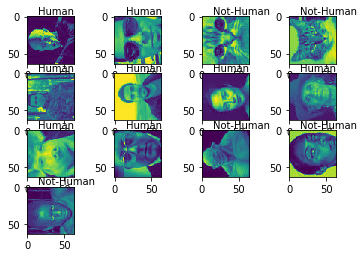

In [143]:
photos = ['myimg.jpg', 'myimg2.jpg', 'myimg3.jpg', 'myimg4.jpg', 'myimg5.jpg', 'myimg6.jpg', 'myimg7.jpg', 'myimg8.jpg', 'myimg9.jpg', 'myimg10.jpg', 'myimg11.jpg', 'myimg12.jpg', 'myimg13.jpg']
for i in range(len(photos)):
    plt.subplot(4,4, i+1)
    predict_new_photo(photos[i])

### run a package with the same parameters to check it

In [ ]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(hidden_layer_sizes=(200, 500, 200), activation='tanh', solver='sgd', alpha=0, learning_rate_init=0.1, max_iter=10000)
clf.fit(train_data, train_label)

print('accuracy on train set:', clf.score(train_data, train_label)*100)
print('accuracy on test set:', clf.score(test_data, test_label)*100)
print('loss:', clf.loss_)

In [ ]:
myimg = mpimg.imread('out.jpg')
print(clf.predict(myimg.reshape(1, -1)))